In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
# import geopandas as gpd
import numpy as np
import os
import scipy as sc
import requests
import datetime
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pal = sns.cubehelix_palette(8, rot=-.222, dark=.1)

/usr/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Clustering

In [20]:
file_final = pd.read_csv('../traffic/file_final.csv', parse_dates=['DATETIME'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M'))

In [76]:
tsne = TSNE()
rows_tsne = tsne.fit_transform(x_norm)

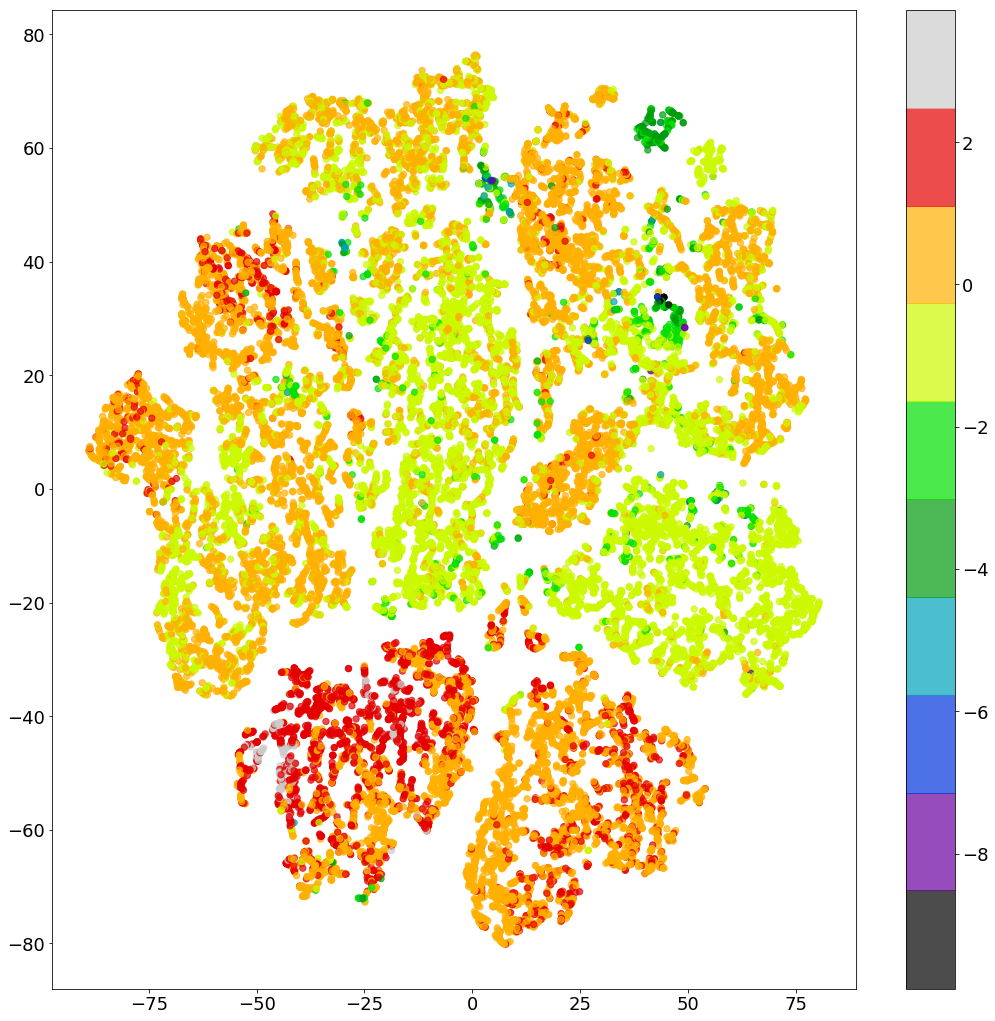

In [77]:
plt.figure(figsize=(2^16, 2^16))
plt.scatter(rows_tsne[:,0], rows_tsne[:,1], alpha=0.7, cmap=plt.cm.get_cmap('nipy_spectral', 10), s=40, c=y)
plt.colorbar()
plt.show()

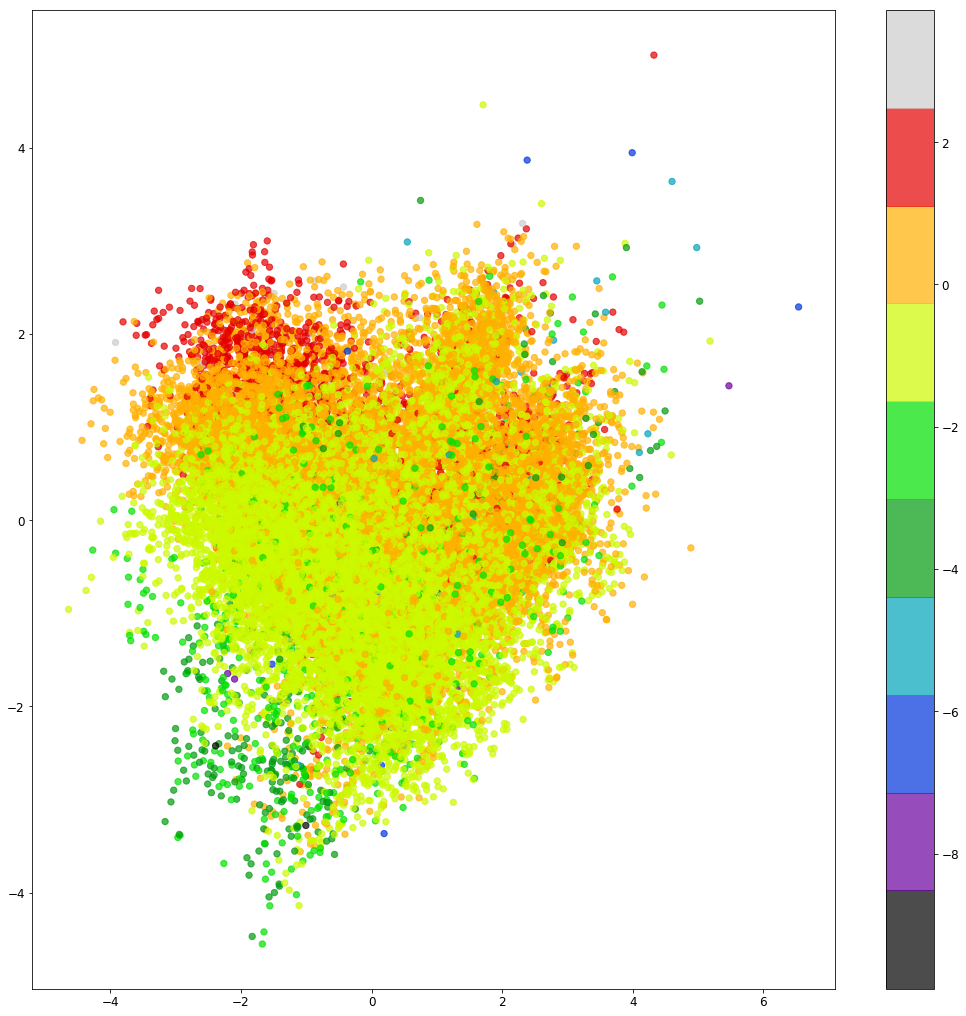

In [62]:
y_norm = rows1['SPEED_MEAN']
x_norm = rows1.drop(['SPEED_MEAN'], axis=1)
pca = PCA(n_components=2, svd_solver='randomized')
rows_ridotto = pca.fit_transform(x_norm)

plt.figure(figsize=(2^16, 2^16))
plt.scatter(rows_ridotto[:,0], rows_ridotto[:,1], alpha=0.7, cmap=plt.cm.get_cmap('nipy_spectral', 10), s=40, c=y)
plt.colorbar()
plt.show()

# **KMeans clusterization.**

**Applying KMeans to raw data (non-normalized)**

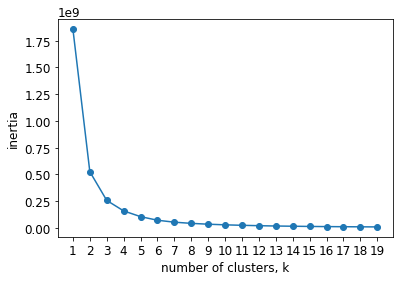

In [63]:
inertias=[]
for k in range (1,20):
    model = KMeans(n_clusters=k)
    model.fit(x_raw)
    inertias.append(model.inertia_)
plt.plot(range(1,20), inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(range(1,20))
plt.show()

In [56]:
def KneeElbowAnalysis(x,max_k=20):
    k_values = range(1,max_k)
    clusterings = [KMeans(n_clusters=k).fit(x) for k in k_values]
    centroids = [clustering.cluster_centers_ for clustering in clusterings]

    D_k = [cdist(x, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/x.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]

    tss = sum(pdist(x)**2)/x.shape[0]
    bss = tss-wcss

    kIdx = 10-1
    
    #
    # elbow curve
    #
    fig = plt.figure(figsize=(12,9));
    font = {'family' : 'sans', 'size'   : 12}
    plt.rc('font', **font)
    plt.plot(k_values, wcss, 'bo-', color='red', label='WCSS')
    plt.plot(k_values, bss, 'bo-', color='blue', label='BCSS')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.legend()
    plt.title('KMeans Clustering');

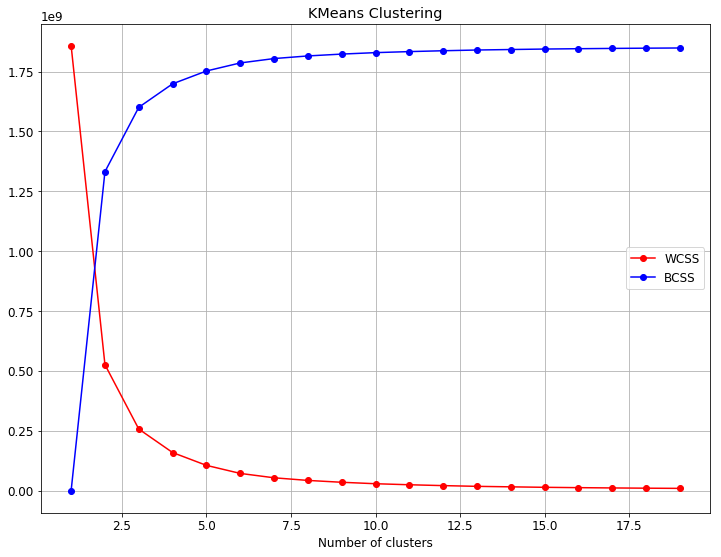

In [64]:
x = x_raw
KneeElbowAnalysis(x, max_k = 20)

**Applying KMeans to normalized data**

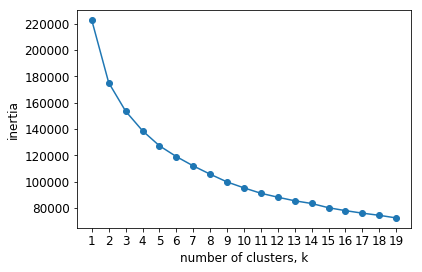

In [65]:
inertias=[]
for k in range (1,20):
    model = KMeans(n_clusters=k)
    model.fit(x_norm)
    inertias.append(model.inertia_)
plt.plot(range(1,20), inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(range(1,20))
plt.show()

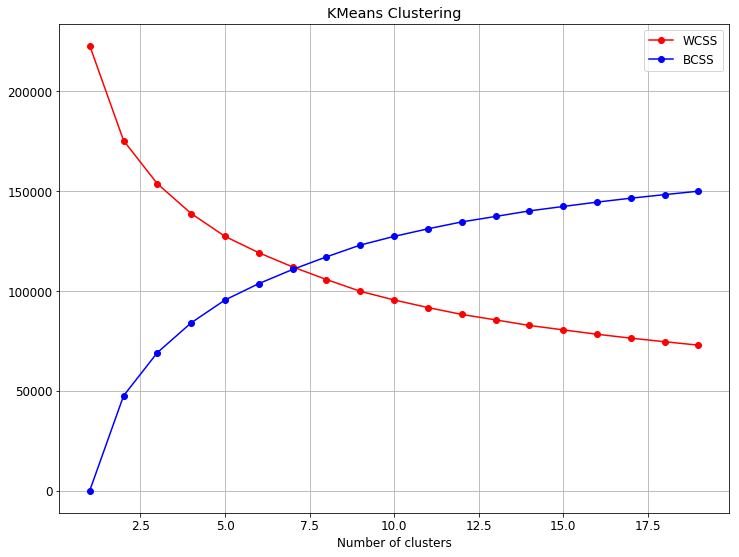

In [66]:
x = x_norm
KneeElbowAnalysis(x, max_k = 20)

**KMeans for TSNE**

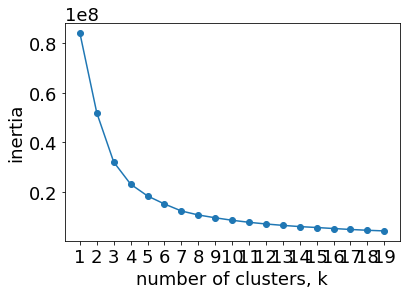

In [78]:
inertias=[]
for k in range (1,20):
    model = KMeans(n_clusters=k)
    model.fit(rows_tsne)
    inertias.append(model.inertia_)
plt.plot(range(1,20), inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(range(1,20))
plt.show()

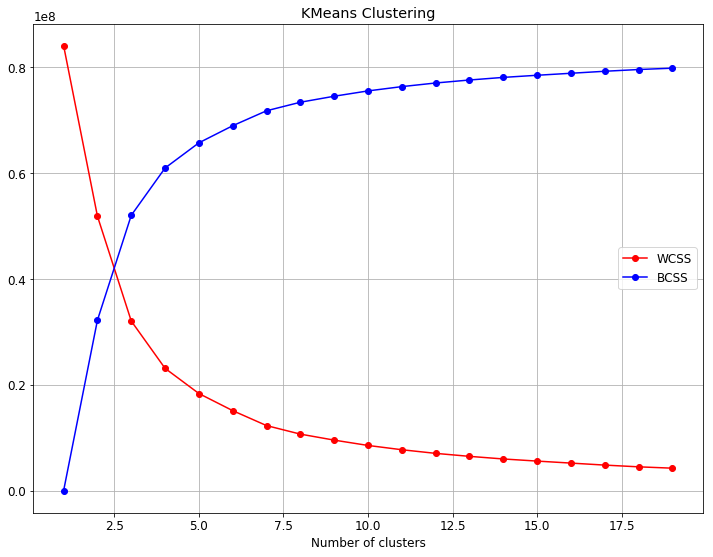

In [79]:
x = rows_tsne
KneeElbowAnalysis(x, max_k = 20)

**Applying KMeans to pca data**

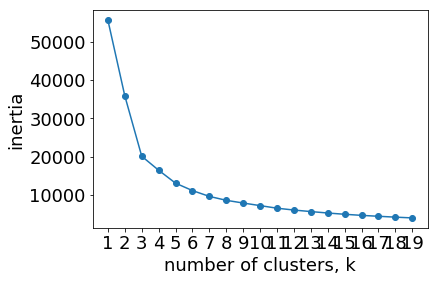

In [44]:
inertias=[]
for k in range (1,20):
    model = KMeans(n_clusters=k)
    model.fit(rows_ridotto)
    inertias.append(model.inertia_)
plt.plot(range(1,20), inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(range(1,20))
plt.show()

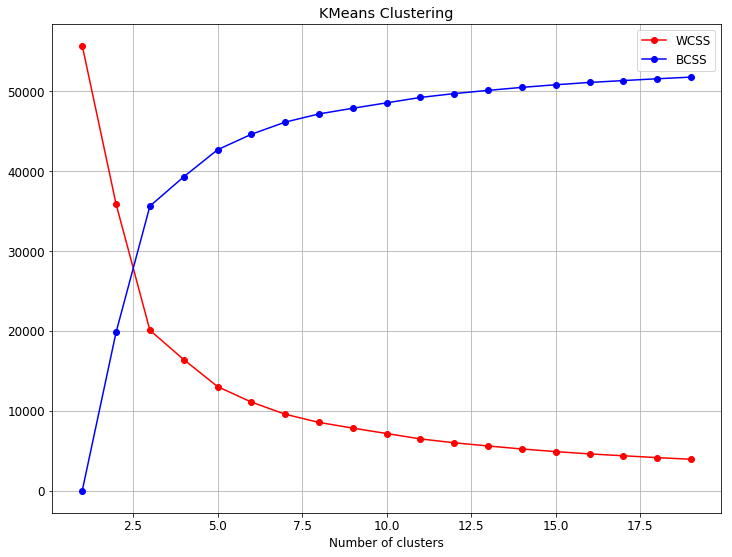

In [58]:
x = rows_ridotto
KneeElbowAnalysis(x, max_k = 20)

# Hierarchical clustering

**Clustering pca values based on hierarchical clustering.**

In [52]:
rows=file_final[['ID_SENSOR', 'DIRECTION', 'NUM_VEHICLES', 'SPEED_MEAN','SPEED_SD', 'Temp', 'Humidity', 'Wind', 'Pressure']].values
matrix = linkage(rows_ridotto, 'average')
# number of cluster
wss_val = []
bss_val = []
k_val = range(1,20)

In [53]:
for k in k_val:
    clustering = fcluster(matrix, k, criterion='maxclust')
    centroids = [np.mean(rows_ridotto[clustering==c],axis=0) for c in range(1,k+1)]
    cdist(rows_ridotto, centroids, 'euclidean')
    D = cdist(rows_ridotto, centroids, 'euclidean')
    cIdx = np.argmin(D,axis=1)
    d = np.min(D,axis=1)
    avgWithinSS = sum(d)/rows_ridotto.shape[0]
    wss = sum(d**2)
    tss = sum(pdist(rows_ridotto)**2)/rows_ridotto.shape[0]
    bss = tss-wss
    wss_val += [wss]
    bss_val += [bss]

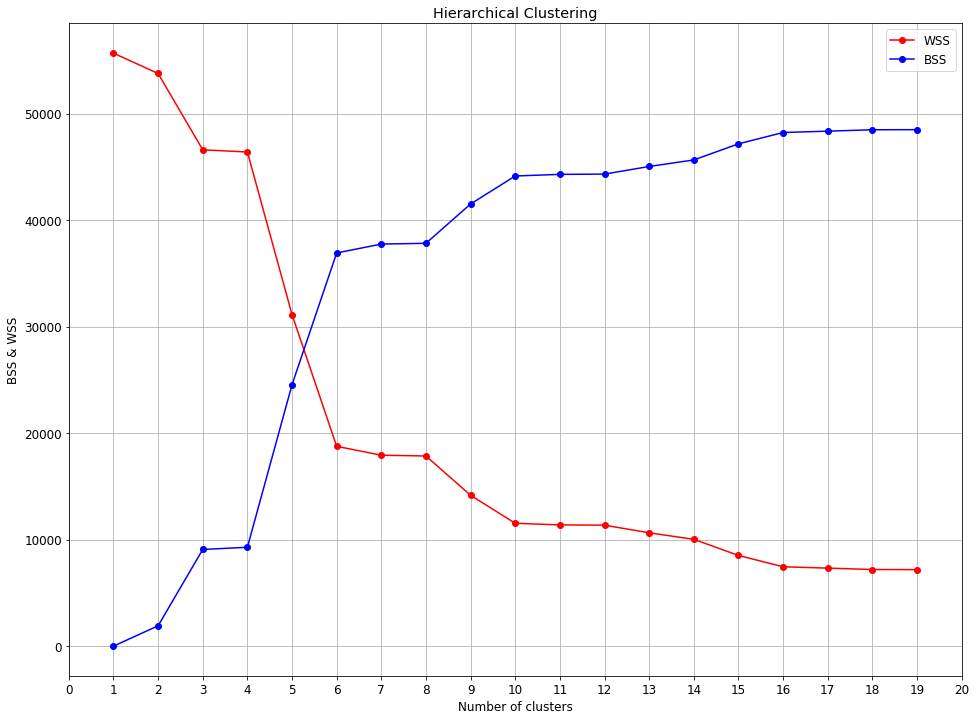

In [54]:
k_val = range(1,20)
fig = plt.figure(figsize=(16,12));
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
plt.plot(k_val, wss_val, 'bo-', color='red', label='WSS')
plt.plot(k_val, bss_val, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(np.arange(0,21,1))
plt.legend()
plt.title('Hierarchical Clustering');

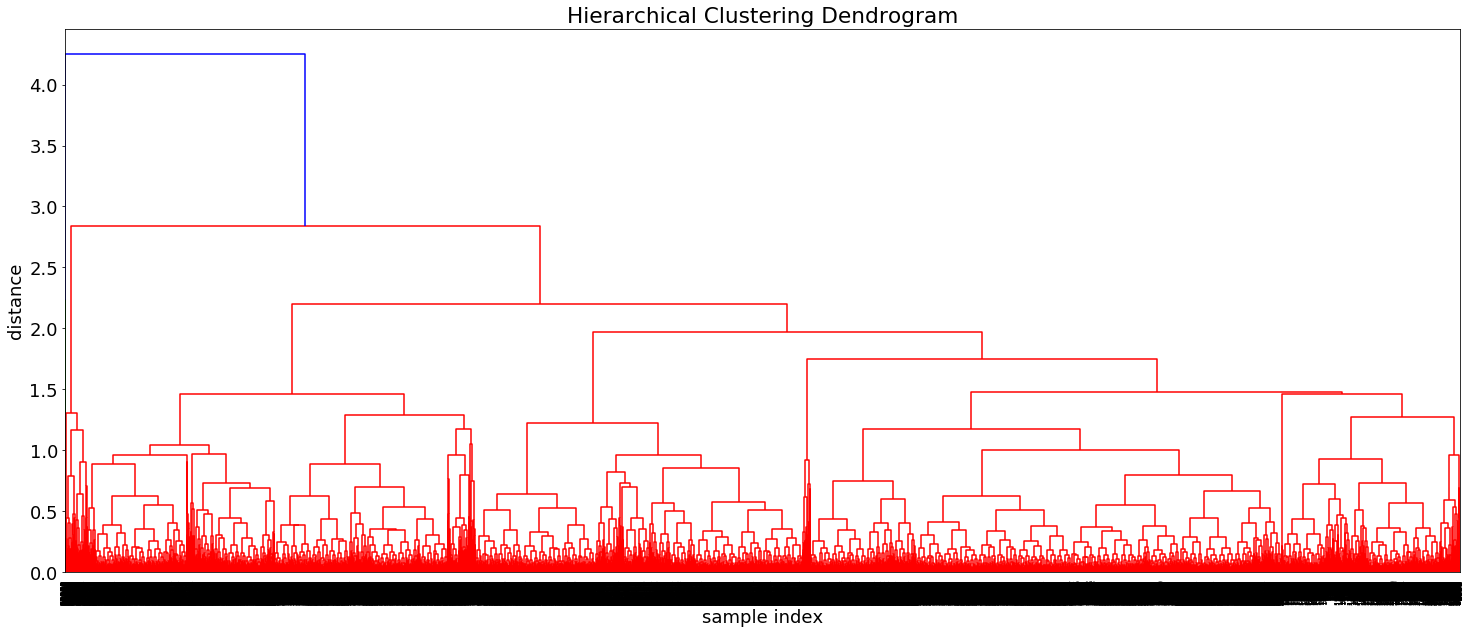

In [55]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(matrix, leaf_rotation = 90, leaf_font_size=8)
plt.show()

**Clustering non-normalized data based on hierarchical clustering.**

In [67]:
matrix = linkage(x_raw, 'average')
# number of cluster
wss_val = []
bss_val = []
k_val = range(1,20)

In [68]:
for k in k_val:
    clustering = fcluster(matrix, k, criterion='maxclust')
    centroids = [np.mean(x_raw[clustering==c],axis=0) for c in range(1,k+1)]
    cdist(x_raw, centroids, 'euclidean')
    D = cdist(x_raw, centroids, 'euclidean')
    cIdx = np.argmin(D,axis=1)
    d = np.min(D,axis=1)
    avgWithinSS = sum(d)/x_raw.shape[0]
    wss = sum(d**2)
    tss = sum(pdist(x_raw)**2)/x_raw.shape[0]
    bss = tss-wss
    wss_val += [wss]
    bss_val += [bss]

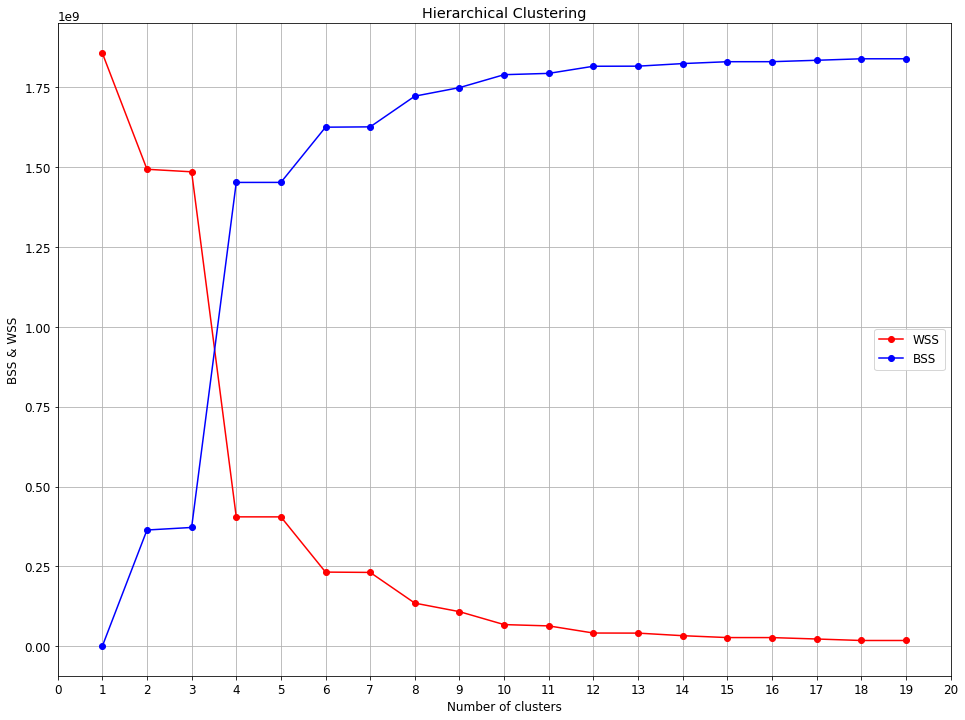

In [69]:
k_val = range(1,20)
fig = plt.figure(figsize=(16,12));
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
plt.plot(k_val, wss_val, 'bo-', color='red', label='WSS')
plt.plot(k_val, bss_val, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(np.arange(0,21,1))
plt.legend()
plt.title('Hierarchical Clustering');

In [43]:
#dendrogram
#grafico tempo e datetime e velocita' ecc.
#cercare un altro tipo del clustering

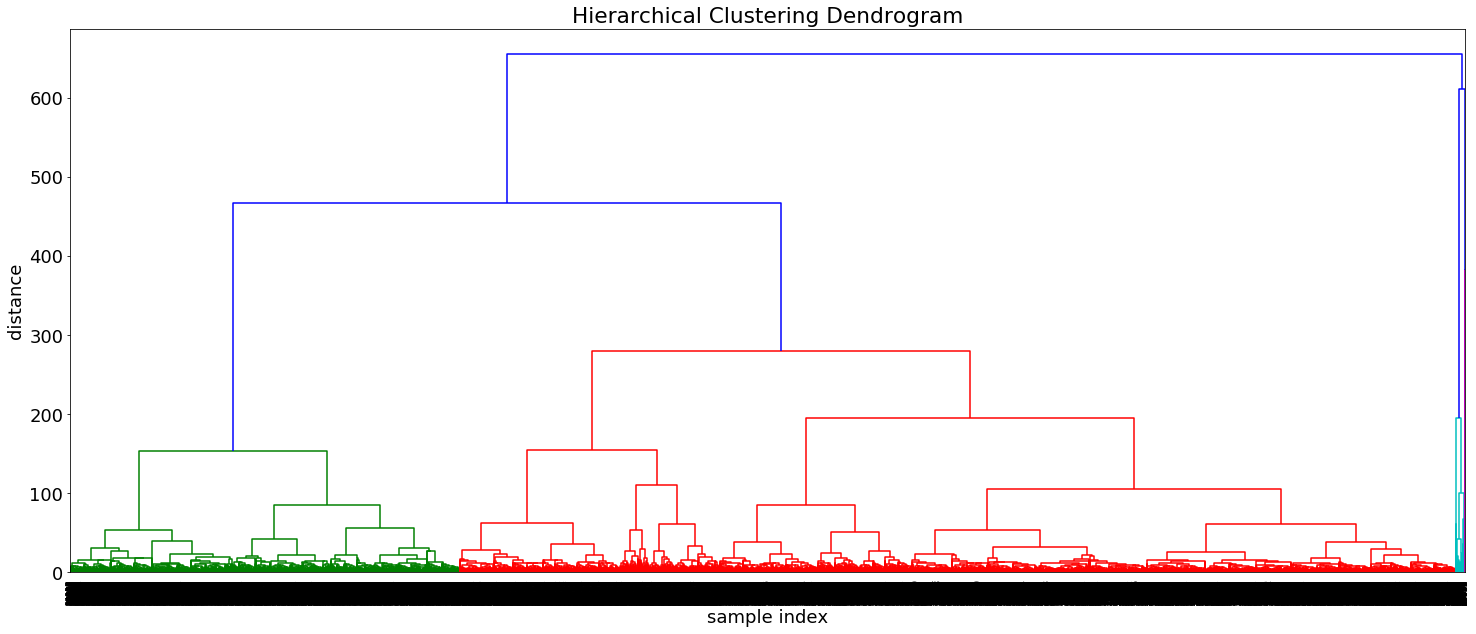

In [70]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(matrix, leaf_rotation = 90, leaf_font_size=8)
plt.show()

**Hierarchical clustering for normalized data.**

In [71]:
matrix = linkage(x_norm, 'average')
# number of cluster
wss_val = []
bss_val = []
k_val = range(1,20)

In [72]:
for k in k_val:
    clustering = fcluster(matrix, k, criterion='maxclust')
    centroids = [np.mean(x_norm[clustering==c],axis=0) for c in range(1,k+1)]
    cdist(x_norm, centroids, 'euclidean')
    D = cdist(x_norm, centroids, 'euclidean')
    cIdx = np.argmin(D,axis=1)
    d = np.min(D,axis=1)
    avgWithinSS = sum(d)/x_norm.shape[0]
    wss = sum(d**2)
    tss = sum(pdist(x_norm)**2)/x_norm.shape[0]
    bss = tss-wss
    wss_val += [wss]
    bss_val += [bss]

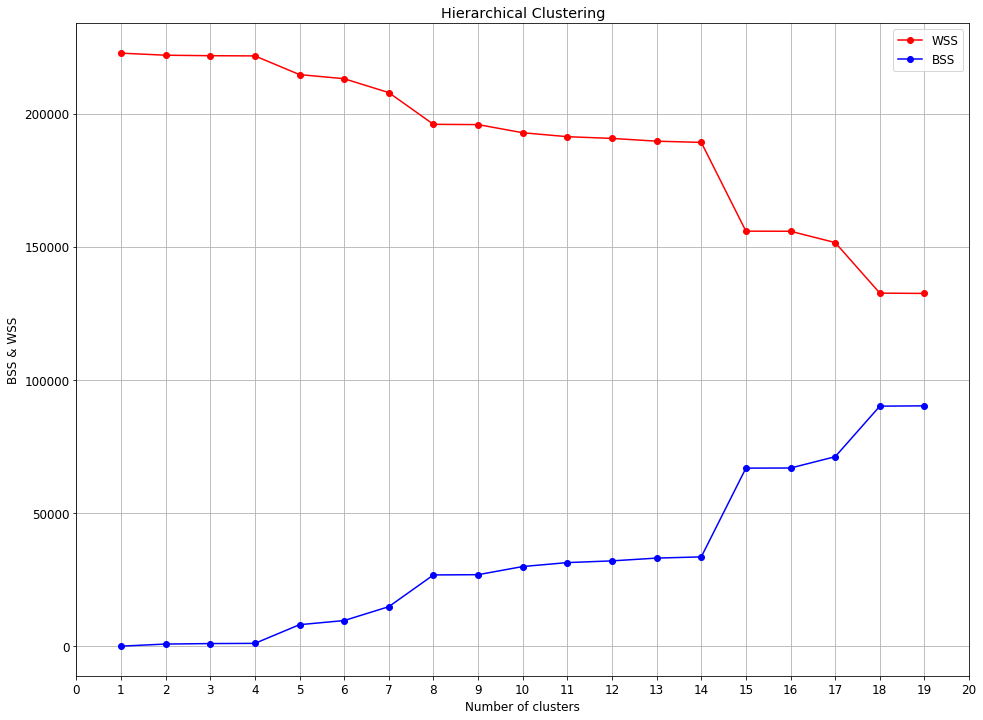

In [73]:
k_val = range(1,20)
fig = plt.figure(figsize=(16,12));
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
plt.plot(k_val, wss_val, 'bo-', color='red', label='WSS')
plt.plot(k_val, bss_val, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(np.arange(0,21,1))
plt.legend()
plt.title('Hierarchical Clustering');

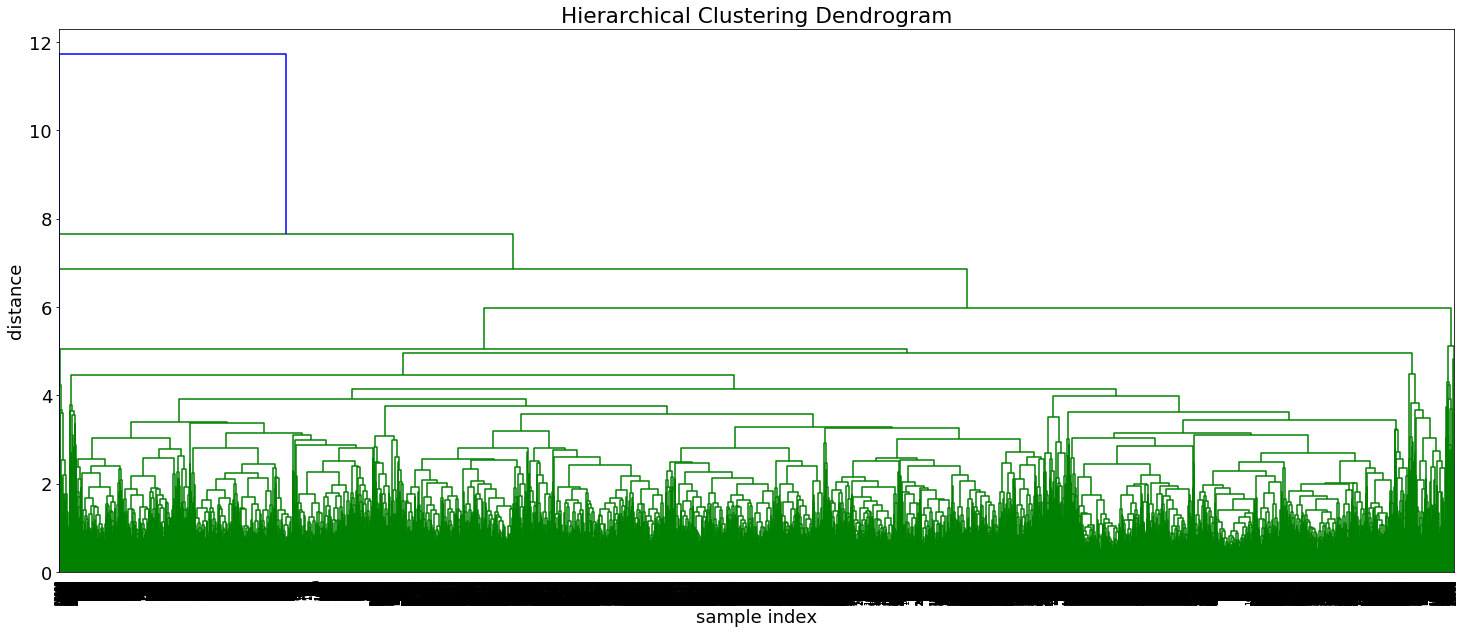

In [74]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(matrix, leaf_rotation = 90, leaf_font_size=8)
plt.show()

In [80]:
matrix = linkage(rows_tsne, 'average')
# number of cluster
wss_val = []
bss_val = []
k_val = range(1,20)

In [81]:
x = rows_tsne
for k in k_val:
    clustering = fcluster(matrix, k, criterion='maxclust')
    centroids = [np.mean(x[clustering==c],axis=0) for c in range(1,k+1)]
    cdist(x, centroids, 'euclidean')
    D = cdist(x, centroids, 'euclidean')
    cIdx = np.argmin(D,axis=1)
    d = np.min(D,axis=1)
    avgWithinSS = sum(d)/x.shape[0]
    wss = sum(d**2)
    tss = sum(pdist(x)**2)/x.shape[0]
    bss = tss-wss
    wss_val += [wss]
    bss_val += [bss]

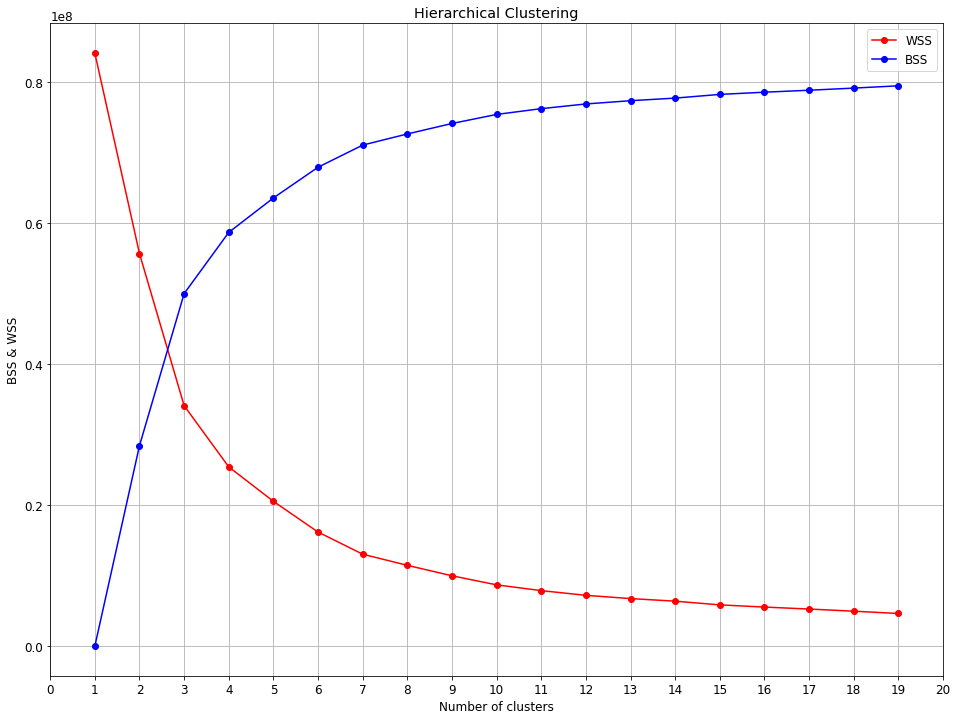

In [82]:
k_val = range(1,20)
fig = plt.figure(figsize=(16,12));
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)
plt.plot(k_val, wss_val, 'bo-', color='red', label='WSS')
plt.plot(k_val, bss_val, 'bo-', color='blue', label='BSS')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('BSS & WSS')
plt.xticks(np.arange(0,21,1))
plt.legend()
plt.title('Hierarchical Clustering');

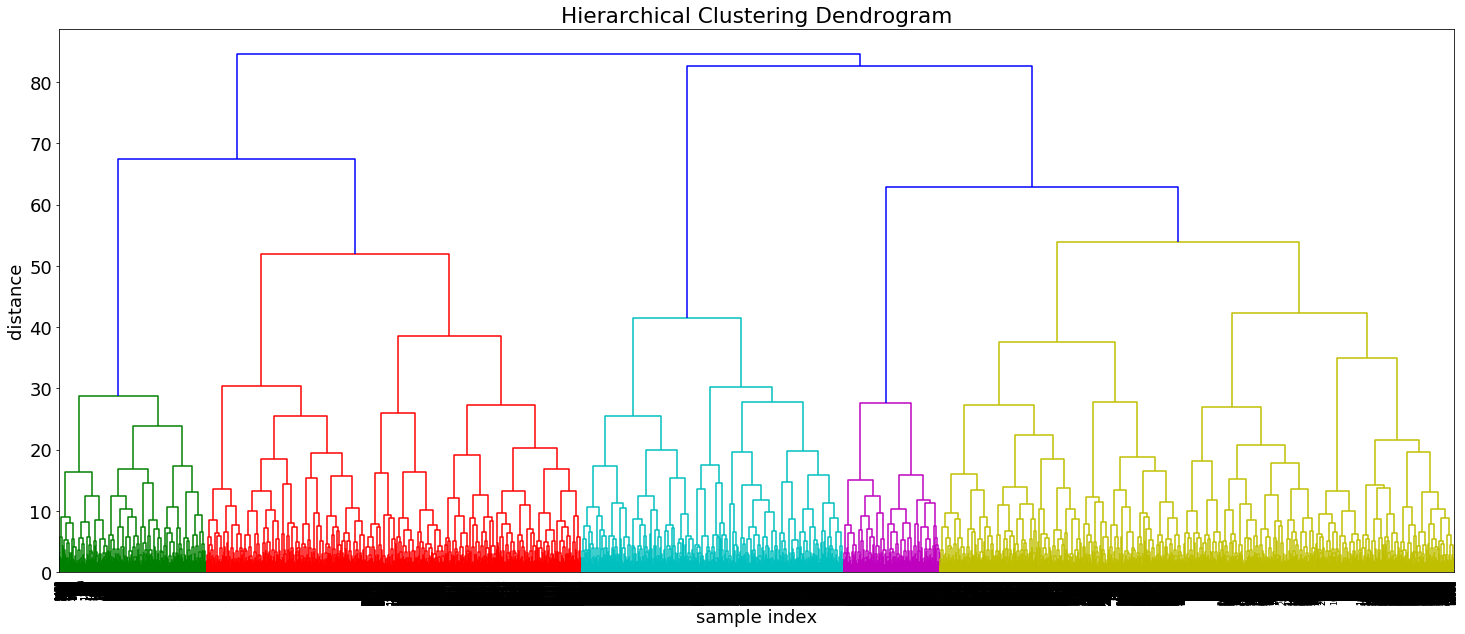

In [83]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(matrix, leaf_rotation = 90, leaf_font_size=8)
plt.show()

In [89]:
clustering_7 = fcluster(matrix, 7, criterion='maxclust')

array([1, 1, 1, ..., 3, 3, 3], dtype=int32)

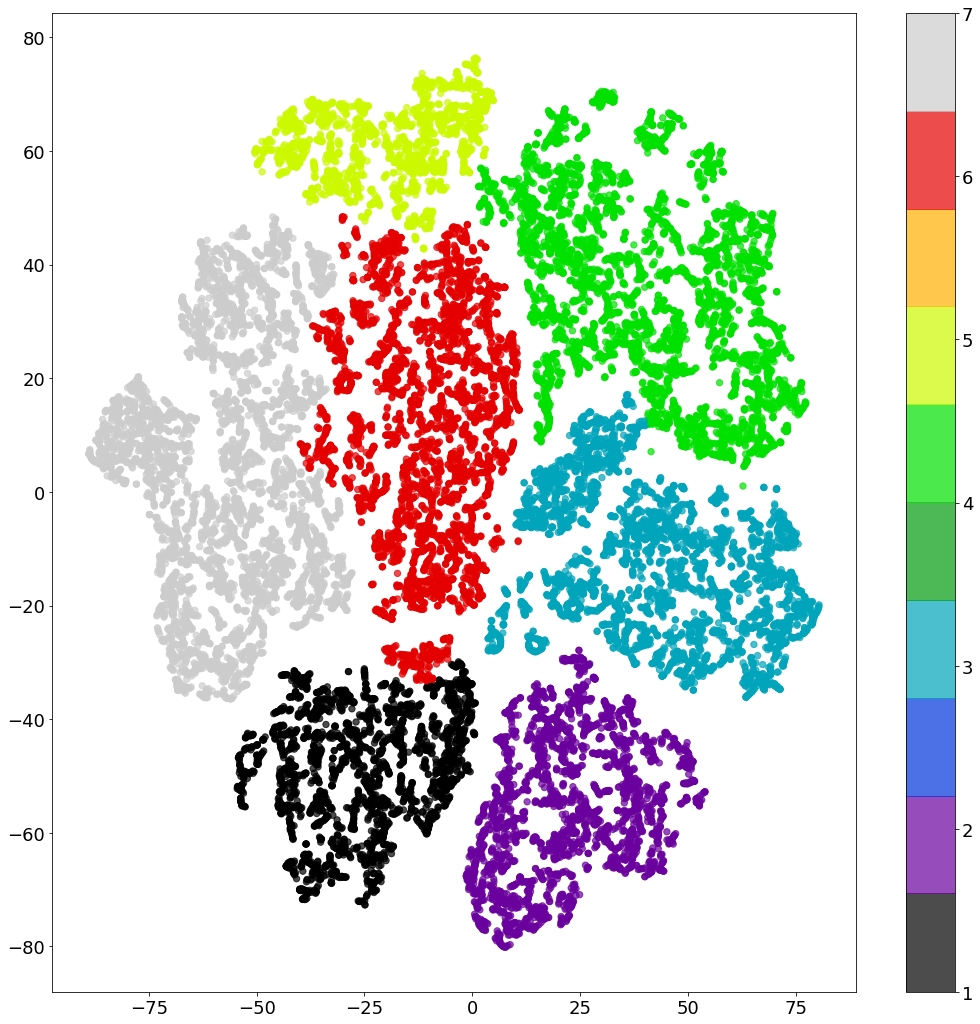

In [92]:
plt.figure(figsize=(2^16, 2^16))
plt.scatter(rows_tsne[:,0], rows_tsne[:,1], alpha=0.7, cmap=plt.cm.get_cmap('nipy_spectral', 10), s=40, c=clustering_7)
plt.colorbar()
plt.show()

In [93]:
clustering_9 = fcluster(matrix, 9, criterion='maxclust')

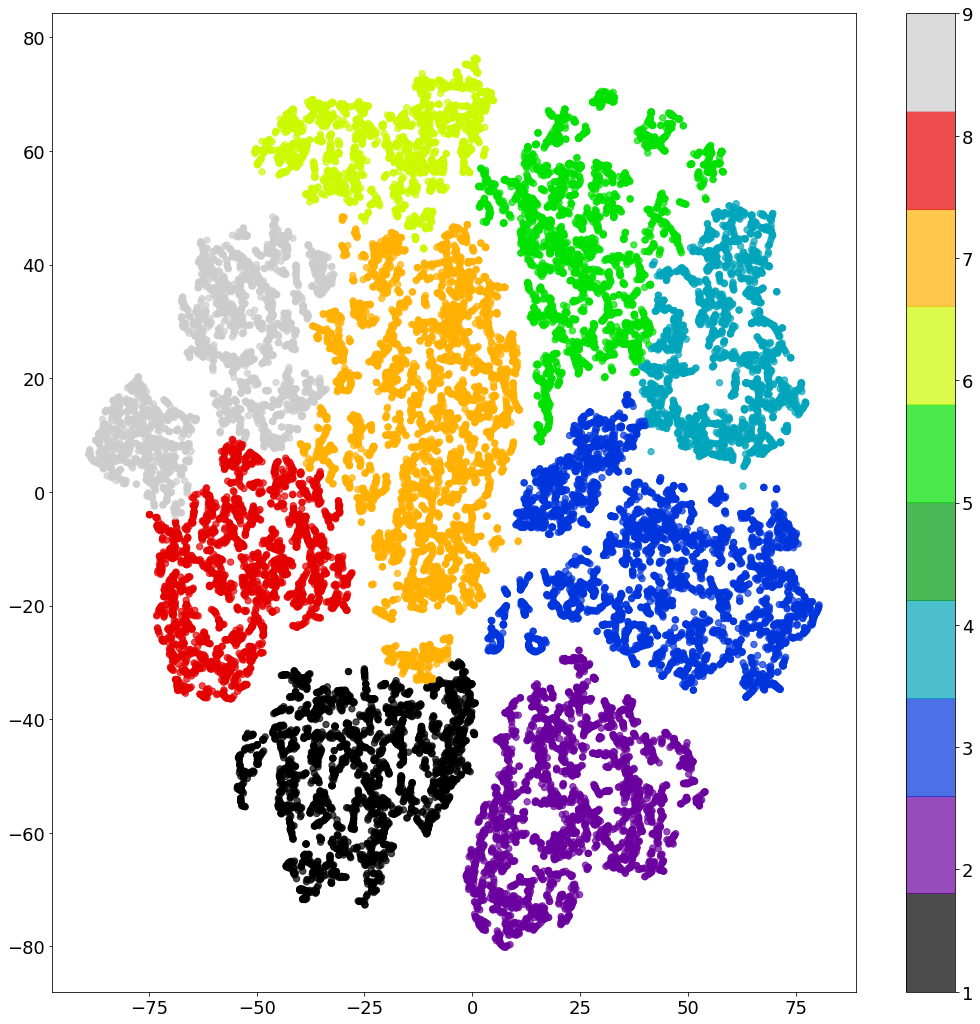

In [95]:
plt.figure(figsize=(2^16, 2^16))
plt.scatter(rows_tsne[:,0], rows_tsne[:,1], alpha=0.7, cmap=plt.cm.get_cmap('nipy_spectral', 10), s=40, c=clustering_9)
plt.colorbar()
plt.show()